# Exercises for Session 3

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize, integrate

### Exercises 1, 2 and 3

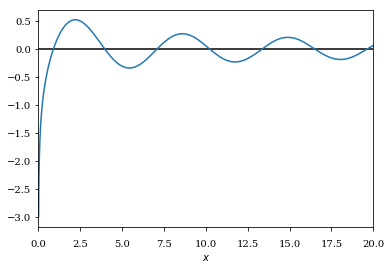

In [2]:
from scipy.special import yv, y0_zeros  # Bessel fn of 2nd kind
    
def f(z):
    return yv(0, z)

x = numpy.arange(0, 20, 0.01)
plt.plot(x, f(x))
plt.hlines(0, 0, 20)
plt.axis(xmin=0, xmax=20)
plt.xlabel('$x$')

In [3]:
def yv0_roots(n):
    i = 1
    prevr = 0.0
    t = 1.0
    dt = 1.0
    integral = 0.0
    rlist = []  # store individual roots for checking
    while i <= n:
        # This is not totally general, but for simplicity we can use the
        # observation that the roots are approx regularly separated
        # (actually root separation tends to pi as n tends to infinity)
        # and select starting points for fsolve which are spaced a
        # bit closer together (here a factor of ~3).
        r, info, flag, mesg = optimize.fsolve(f, t, full_output=True)
        r = r[0]
        deltar = abs(r - prevr)
        # need to be careful to reject solutions that have been
        # found previously or are too distant from starting point
        if flag == 1 and abs(r - prevr) > 1e-5 and abs(r - t) < 1.5*dt:
            # just add integral over new range, which is faster and more
            # accurate when there are many oscillations within full range
            a, aerr = integrate.quad(f, prevr, r)
            integral += a
            if i == n:
                print('Root {:d} is at {:.3f}'.format(i, r))
                print('Integral from zero to root {:d} is {:.3g}'.format(i, integral))
            i += 1
            prevr = r
            rlist.append(r)
        t += dt
    return np.array(rlist)

In [4]:
n = 20
roots = yv0_roots(n)
roots

Root 20 is at 60.478
Integral from zero to root 20 is 0.103


array([  0.89357697,   3.95767842,   7.08605106,  10.22234504,
        13.36109747,  16.50092244,  19.6413097 ,  22.78202805,
        25.92295765,  29.06403025,  32.20520412,  35.34645231,
        38.48775665,  41.62910447,  44.77048661,  47.91189633,
        51.05332855,  54.19477936,  57.3362457 ,  60.47772516])

In [5]:
# check roots
if n < 140:
    # this uses an hardcoded method which only applies up to n=139
    rtrue = y0_zeros(n)[0]
    ok = (numpy.abs(rtrue - roots) < 1e-5).all()
    print('Checks OK:', ok)
else:
    # check the interval between each root is sensible (tested to n = 10000)
    d = roots[1:] - roots[:-1]
    ok = (d > 3) & (d < numpy.pi+1e-5)
    print('Checks OK:', ok.all())
    if not ok.all():
        bad = numpy.logical_not(ok)
        printbad.nonzero()[0], d[bad]

Checks OK: True


### Exercises 4, 5 and 6

In [6]:
# create 100 samples from a Normal distribution
# with mean 5 and standard deviation 1
np.random.seed(54321)
n = 100
m = 5
s = 1
d = stats.norm.rvs(m, s, size=n)

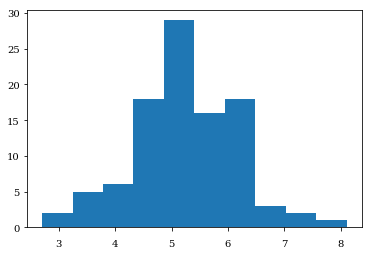

In [7]:
# histogram the data - this can be done with numpy,
# or simultaneously with plotting with pyplot
#hx, hy = numpy.histogram(d, bins=10)
hy, hx, p = plt.hist(d, bins=10, histtype='stepfilled')

In [8]:
# get the width of the bins and hence normalisation
w = hx[1]-hx[0]
a = n*w
# get the centres of the bins
hxc = 0.5*(hx[:-1] + hx[1:])

In [9]:
# returns the value of a Gaussian with specified amplitude,
# mean and sigma, evaluated at x (just for convenience)
def g(p, a, x):
    m, s = p
    return a * stats.norm.pdf(x, m, s)

In [10]:
# returns chisq of specified Gaussian for data (x, y)
def f(p, a, x, y):
    return ((y - g(p, a, x))**2).sum()

In [11]:
# find parameter set which minimises chisq
results = optimize.minimize(f, (3, 3), args=(a, hxc, hy))
results

      fun: 101.20417934635331
 hess_inv: array([[  4.10260182e-04,   1.14938238e-05],
       [  1.14938238e-05,   3.01092772e-04]])
      jac: array([  0.00000000e+00,  -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 481
      nit: 9
     njev: 120
   status: 0
  success: True
        x: array([ 5.26031668,  0.8557135 ])

In [12]:
# Specify parameter bounds
results = optimize.minimize(f, (3, 3), args=(a, hxc, hy), bounds=((None, None), (0.01, None)))
results

      fun: 101.20417934635324
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.10542736e-06,   8.52651283e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 81
      nit: 15
   status: 0
  success: True
        x: array([ 5.26031668,  0.8557135 ])

In [13]:
# get fit parameters
r1 = results.x

In [14]:
# use MLE method provided in stats (actually understands that this is samples from a distribution)
r2 = stats.norm.fit(d)

true function:  mean = 5.000, sigma = 1.000
optimize.fmin:  mean = 5.260, sigma = 0.856
stats.norm.fit: mean = 5.223, sigma = 0.939


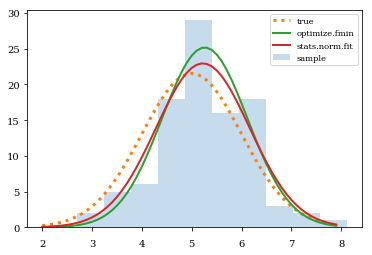

In [15]:
# plot true function and fit results over histogram
x = np.arange(m-3*s, m+3*s, s/10.0)
plt.hist(d, bins=hx, histtype='stepfilled', linestyle=None,
         alpha=0.25, label='sample')
plt.plot(x, g((m, s), a, x), ':', label='true', lw=3)
plt.plot(x, g(r1, a, x), label='optimize.fmin', lw=2)
plt.plot(x, g(r2, a, x), label='stats.norm.fit', lw=2)
plt.legend(prop={'size':'small'})

# neatly print results to screen
print('true function:  mean = {:5.3f}, sigma = {:5.3f}'.format(m, s))
print('optimize.fmin:  mean = {:5.3f}, sigma = {:5.3f}'.format(*r1))
print('stats.norm.fit: mean = {:5.3f}, sigma = {:5.3f}'.format(*r2))

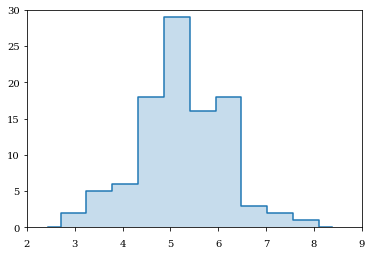

In [16]:
# Additional note:
# trick for drawing a binned function without original sample
# add zero bins at each end of distribution
hhxc = np.concatenate(([hxc[0]-w], hxc, [hxc[-1]+w]))
hhy = np.concatenate(([0], hy, [0]))
plt.plot(hhxc, hhy, drawstyle='steps-mid', label='sample')
plt.fill_between(hhxc, 0, hhy, step='mid', alpha=0.25)
_ = plt.axis(xmin=2, xmax=9, ymin=0, ymax=30)